In [1]:
import  numpy as np
import matplotlib.pyplot as plt
from tools import *
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from scipy import stats
from sklearn.svm import SVC
from mnist import MNIST

In [2]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    """ l : liste des chiffres a extraire"""
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =  list( zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")
    
xusps,yusps = load_usps("datas/usps/USPS_train.txt")

In [3]:
def analyse_data(y, L):
    label_L, count_L = np.unique(y[:L], return_counts=True)
    label_U, count_U = np.unique(y[L:], return_counts=True)
    
    
    if np.any(label_L != label_U):
        print("Test data has unknown labels. Please re-select again.")
        return
    
    colors = np.random.rand(len(label_L), 3,1)
    plt.figure(figsize=(6, 6))
    
    for i, label in enumerate(label_L):
        plt.bar(1.5, count_L[i], width=0.3, bottom=np.sum(count_L[:i]), alpha=0.8, color=colors[i], label = str(label))
        plt.bar(3, count_U[i], width=0.3, bottom=np.sum(count_U[:i]), alpha=0.8, color=colors[i])
    
    plt.title("The paritition of dataset")
    plt.xticks([1.5, 3], ['labeled', 'unlabeled'])
    plt.grid()
    plt.legend()
    plt.show()

Load USPS data...

Data shape: 1200 * 256

Labeled num: 60

Unlabeld num: 1140


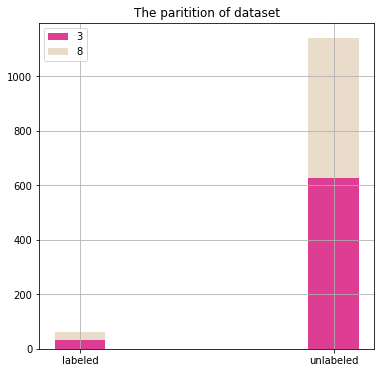

In [4]:
# Définition de la base d'apprentissage
xuspstrain,yuspstrain = get_usps([3, 8],xusps,yusps)
data = xuspstrain
(n,m) = np.shape(data)

# shuffle data
idx = np.random.permutation(n)
data = data[idx]
yuspstrain = yuspstrain[idx]

# Pourcentage de la base d'apprentissage non étiquettée
percent_u = 95./100.
# nombre de données non étiquettées
U = int(percent_u * n)
# nombre de données étiquettées
L =  n-U

# étiquettes connues
labels = yuspstrain[:L]
# étiquettes à prédire
labpredire = yuspstrain[L:]

print("Load USPS data...\n")
print("Data shape: %d * %d" % data.shape)
print("\nLabeled num: %d" % L)
print("\nUnlabeld num: %d" % U)
analyse_data(yuspstrain, L)

In [5]:
class DiffusionTRESH:
        
    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)

        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        fu = np.dot(np.dot(np.linalg.pinv(self.D[self.L:,self.L:] - self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
            
    def fit(self, data, labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(np.shape(data)[1])])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
        
    def score(self, labels):
        return (self.predict()==labels).mean()

In [6]:
M = DiffusionTRESH()
M.fit(data,labels)
print("The score of Diffusion by threshold is %f" % M.score(labpredire))

The score of Diffusion by threshold is 0.961404


In [7]:
class DiffusionCMN:

    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        
        # calculate fu
        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        desirable_proportions = y.sum(0) + 1
        fu = np.dot(np.dot(np.linalg.pinv(self.D[self.L:,self.L:]-self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
        fu = fu * (desirable_proportions / fu.sum(0))

        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
            
    def fit(self,data,labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(np.shape(data)[1])])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
    def score(self,labels):
        return (self.predict()==labels).mean()

In [8]:
M = DiffusionCMN()
M.fit(data,labels)
print("The score of Diffusion by class prior is %f" % M.score(labpredire))

The score of Diffusion by class prior is 0.961404


In [9]:
class DiffusionTRESHSVM:

    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        
        # calculate fu
        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        fu = np.dot(np.dot(np.linalg.inv(self.D[self.L:,self.L:]-self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
        fu = fu * self.hu
        
        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
            
    def fit(self,data,labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(np.shape(data)[1])])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
        # train svm
        clf = SVC(C=2, probability = True)
        clf.fit(data[:self.L], labels)
        self.hu = clf.predict_proba(data[self.L:])
        
    def score(self,labels):
        return (self.predict()==labels).mean()

In [10]:
M = DiffusionTRESHSVM()
M.fit(data,labels)
print("The score of Diffusion by class prior is %f" % M.score(labpredire))

The score of Diffusion by class prior is 0.971930


In [17]:
class DiffusionLEARN:
    
    def __init__(self, eps=0.01, lr = 1.0):        
        self.eps = eps
        self.lr = lr

    def oracle(self, sgm, max_iter):
        
        self.h_histo = [1000]
        self.dh_histo = None
        
        for i in range(max_iter):
            # calculate W
            data_sgm = self.data / sgm
            self.W = np.exp(-euclidean_distances(data_sgm) ** 2)
            # calculate D
            diago = np.sum(self.W,axis=1)
            self.D = np.diag(diago)
            # calculate P
            P = np.dot(np.linalg.inv(self.D), self.W)
            Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
            # calculate fu
            fu = np.dot(np.dot(np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:]), Ps[self.L:, :self.L]), self.fl)
            # calculate H
            self.h_histo.append(self.H(fu))
            # if this is the right direction
            if self.h_histo[-1] <= self.h_histo[-2]:
                # calculate the gradient of H
                dh = self.gradH(fu, P, sgm)
                print i
                print self.h_histo[-1]
                print dh
                print sgm
                self.dh_histo = np.hstack((self.dh_histo, dh)) if self.dh_histo != None else dh
                if np.abs(dh) < 1e-10 or self.lr < 1e-8:
                    break
                else:
                    sgm = sgm - self.lr * dh
            else:
                self.lr = self.lr / 5
                print "lr = ", self.lr
                
        self.sigmas = sgm
        
        return
        

    def H(self, fu):
        return - (fu * np.log(fu)).sum() / self.U

    def gradH(self, fu, P, sgm):
        
        Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
        
        dw_sgm = 2 * self.W * (euclidean_distances(self.data) ** 2) / (sgm ** 3)
        # formule 14
        sum_dw = dw_sgm.sum(1).reshape((-1, 1))
        sum_w = self.W.sum(1).reshape((-1, 1))
        dps_sgm = (1 - self.eps) * (dw_sgm - P * sum_dw) / sum_w
        # formule 13
        dfu_sgm_1 = np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:])
        dfu_sgm_2 = dps_sgm[self.L:, self.L:].dot(fu) + dps_sgm[self.L:, :self.L].dot(self.fl)
        dfu_sgm = np.dot(dfu_sgm_1, dfu_sgm_2)
        # formule 12
        dh_sgm = (fu[:,0] / fu[:, 1] * dfu_sgm[:, 1]).sum() / self.U
        # save result
         
        return dh_sgm

    def fit(self, data, labels):
        self.labels = labels
        self.data = data
        self.L = labels.shape[0]
        self.U = data.shape[0] - self.L
        self.D = data.shape[1]
        
    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        # calculate fl
        self.fl = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        sgm = 5
        # optimisation
        self.oracle(sgm, 500)
        # predict
        
        # calculate W
        data_n = self.data / self.sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
        # calculate fu
        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        desirable_proportions = y.sum(0) + 1
        fu = np.dot(np.dot(np.linalg.pinv(self.D[self.L:,self.L:]-self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
        fu = fu * (desirable_proportions / fu.sum(0))

        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
    
    def score(self, labels):
        return (self.predict()==labels).mean()

In [155]:
M = DiffusionLEARN()
M.fit(data,labels)
print("The score of Diffusion by learning w is %f" % M.score(labpredire))

0
0.675526296365
0.0250648924825
5
1
0.674923822849
0.0260127338153
4.97493510752
2
0.674274368517
0.0270189629932
4.9489223737


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:34: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


3
0.673573027682
0.0280864051284
4.92190341071
4
0.6728143613
0.0292173598562
4.89381700558
5
0.671992371053
0.0304132636314
4.86459964572
6
0.671100492886
0.0316742201243
4.83418638209
7
0.670131623119
0.0329983560808
4.80251216197
8
0.669078196129
0.0343809507726
4.76951380589
9
0.667932340375
0.0358132799064
4.73513285512
10
0.666686149189
0.0372811142408
4.69931957521
11
0.665332113682
0.038762827795
4.66203846097
12
0.663863775246
0.0402271149991
4.62327563317
13
0.662276659772
0.0416304125374
4.58304851817
14
0.66056954597
0.0429142989036
4.54141810564
15
0.658746081538
0.0440034311166
4.49850380673
16
0.656816673791
0.0448049803881
4.45450037562
17
0.654800427486
0.045210989545
4.40969539523
18
0.652726682858
0.0451054075303
4.36448440568
19
0.650635471356
0.0443773764636
4.31937899815
20
0.648576086211
0.0429410930246
4.27500162169
21
0.646603163276
0.0407597909636
4.23206052866
22
0.644770353541
0.0378674945144
4.1913007377
23
0.643122757199
0.0343792411085
4.15343324319
24
0.

In [14]:
class DiffusionGraph:
    
    def __init__(self, eps=0.01, lr = 1.0):        
        self.eps = eps
        self.lr = lr

    def oracle(self, sgm, max_iter):
        
        self.h_histo = [1000]
        self.dh_histo = None
        
        for i in range(max_iter):
            # calculate W
            data_sgm = self.data / sgm
            self.W = np.exp(-euclidean_distances(data_sgm) ** 2)
            # calculate D
            diago = np.sum(self.W,axis=1)
            self.D = np.diag(diago)
            # calculate P
            P = np.dot(np.linalg.inv(self.D), self.W)
            Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
            # calculate fu
            fu = np.dot(np.dot(np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:]), Ps[self.L:, :self.L]), self.fl)
            # calculate H
            self.h_histo.append(self.H(fu))
            # if this is the right direction
            if self.h_histo[-1] <= self.h_histo[-2]:
                # calculate the gradient of H
                dh = self.gradH(fu, P, sgm)
                print i
                print self.h_histo[-1]
                print dh
                print sgm
                self.dh_histo = np.hstack((self.dh_histo, dh)) if self.dh_histo != None else dh
                if np.abs(dh) < 1e-10 or self.lr < 1e-8:
                    break
                else:
                    sgm = sgm - self.lr * dh
            else:
                self.lr = self.lr / 5
                print "lr = ", self.lr
                
        self.sigmas = sgm
        
        return
        

    def H(self, fu):
        return - (fu * np.log(fu)).sum() / self.U

    def gradH(self, fu, P, sgm):
        
        Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
        
        dw_sgm = 2 * self.W * (euclidean_distances(self.data) ** 2) / (sgm ** 3)
        # formule 14
        sum_dw = dw_sgm.sum(1).reshape((-1, 1))
        sum_w = self.W.sum(1).reshape((-1, 1))
        dps_sgm = (1 - self.eps) * (dw_sgm - P * sum_dw) / sum_w
        # formule 13
        dfu_sgm_1 = np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:])
        dfu_sgm_2 = dps_sgm[self.L:, self.L:].dot(fu) + dps_sgm[self.L:, :self.L].dot(self.fl)
        dfu_sgm = np.dot(dfu_sgm_1, dfu_sgm_2)
        # formule 12
        dh_sgm = (fu[:,0] / fu[:, 1] * dfu_sgm[:, 1]).sum() / self.U
        # save result
         
        return dh_sgm

    def fit(self, data, labels, labelspred):
        self.labels = labels
        self.data = data
        self.L = labels.shape[0]
        self.U = data.shape[0] - self.L
        self.D = data.shape[1]
        self.pred = labelspred
        
    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        # calculate fl
        self.fl = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)

        self.h_histo = []
        self.score_histo = []
        self.sigma_histo = np.arange(0.5, 10, 0.1)
        
        for sgm in self.sigma_histo:
        
            # calculate W
            data_n = self.data / sgm
            self.W = np.exp(-euclidean_distances(data_n)**2)
        
            # calculate D
            diago = np.sum(self.W,axis=1)
            self.D = np.diag(diago)
        
            # calculate fu
            y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
            p = (1 - 0) * np.linalg.inv(self.D).dot(self.W) + 0 / (self.L + self.U)
            fu = (np.linalg.inv(np.eye(self.U) - p[self.L:, self.L:]).dot(p[self.L:, :self.L])).dot(y)
            #print fu
            #fu = np.dot(np.dot(np.linalg.pinv(self.D[self.L:,self.L:] - self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
            prediction = set_labels[np.argmax(fu, axis = 1)]
            
            self.h_histo.append(self.H(fu))
            self.score_histo.append((prediction == self.pred).mean())
    
    def score(self, labels):
        return (self.predict()==labels).mean()

In [15]:
M = DiffusionGraph()
M.fit(data, labels, labpredire)
M.predict()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in log


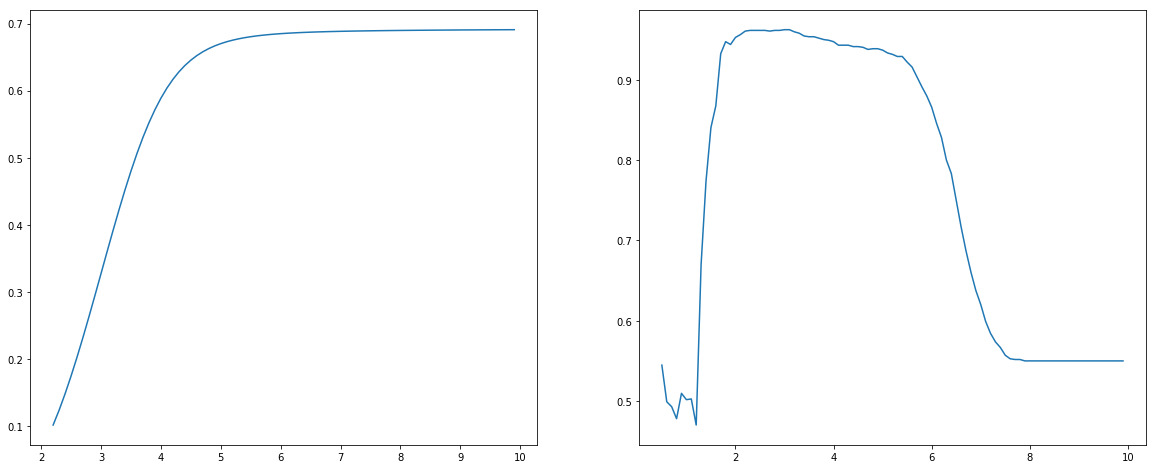

0.5
3.0
0.962280701754


In [16]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(M.sigma_histo, M.h_histo)
plt.subplot(1, 2, 2)
plt.plot(M.sigma_histo, M.score_histo)
plt.show()
print M.sigma_histo[np.argmin(np.array(M.h_histo))]
print M.sigma_histo[np.argmax(np.array(M.score_histo))]
print np.max(np.array(M.score_histo))